In [2]:
!pip install pandas numpy matplotlib rouge

In [3]:
import pandas as pd
import numpy as np
from rouge import Rouge
import csv

# Read the CSV file with Malayalam content
# Make sure to specify the encoding if needed (commonly utf-8)
df = pd.read_csv('evaluationSet.csv', encoding='utf-8')

# If column names are different, adjust accordingly
# Expected columns: Questions, Reference Answer, GraphRAG generated answer, RAG generated answer
print(df.columns)
print(f"Total number of QA pairs: {len(df)}")

Index(['Question', 'Reference Answer', 'GraphRAG Answer', 'RAG Answer'], dtype='object')
Total number of QA pairs: 49


In [4]:
# Initialize Rouge calculator
rouge = Rouge()

# Lists to store individual scores
graphrag_scores = []
rag_scores = []

# Calculate ROUGE scores for each row
for index, row in df.iterrows():
    reference = row['Reference Answer']
    graphrag_answer = row['GraphRAG Answer']
    rag_answer = row['RAG Answer']
    
    # Skip invalid entries (empty answers)
    if not isinstance(reference, str) or not isinstance(graphrag_answer, str) or not isinstance(rag_answer, str):
        continue
    
    if len(reference.strip()) == 0 or len(graphrag_answer.strip()) == 0 or len(rag_answer.strip()) == 0:
        continue
    
    try:
        # Calculate scores for GraphRAG
        graphrag_score = rouge.get_scores(graphrag_answer, reference)[0]
        graphrag_scores.append(graphrag_score)
        
        # Calculate scores for RAG
        rag_score = rouge.get_scores(rag_answer, reference)[0]
        rag_scores.append(rag_score)
    except Exception as e:
        print(f"Error calculating scores for row {index}: {e}")

In [5]:
def calculate_average_scores(scores_list):
    if not scores_list:
        return None
    
    # Initialize dictionaries to store sums
    rouge1_sum = {'f': 0, 'p': 0, 'r': 0}
    rouge2_sum = {'f': 0, 'p': 0, 'r': 0}
    rougeL_sum = {'f': 0, 'p': 0, 'r': 0}
    
    # Sum up all scores
    for score in scores_list:
        for metric in ['f', 'p', 'r']:
            rouge1_sum[metric] += score['rouge-1'][metric]
            rouge2_sum[metric] += score['rouge-2'][metric]
            rougeL_sum[metric] += score['rouge-l'][metric]
    
    # Calculate averages
    n = len(scores_list)
    avg_scores = {
        'rouge-1': {metric: value/n for metric, value in rouge1_sum.items()},
        'rouge-2': {metric: value/n for metric, value in rouge2_sum.items()},
        'rouge-l': {metric: value/n for metric, value in rougeL_sum.items()}
    }
    
    return avg_scores

# Calculate average scores
avg_graphrag_scores = calculate_average_scores(graphrag_scores)
avg_rag_scores = calculate_average_scores(rag_scores)

# Print comparison
print("\nAverage ROUGE Scores Comparison:")
print("\nGraphRAG scores:")
for rouge_type in ['rouge-1', 'rouge-2', 'rouge-l']:
    print(f"  {rouge_type}: F1={avg_graphrag_scores[rouge_type]['f']:.4f}, Precision={avg_graphrag_scores[rouge_type]['p']:.4f}, Recall={avg_graphrag_scores[rouge_type]['r']:.4f}")

print("\nRAG scores:")
for rouge_type in ['rouge-1', 'rouge-2', 'rouge-l']:
    print(f"  {rouge_type}: F1={avg_rag_scores[rouge_type]['f']:.4f}, Precision={avg_rag_scores[rouge_type]['p']:.4f}, Recall={avg_rag_scores[rouge_type]['r']:.4f}")

# Calculate and print the differences
print("\nDifference (GraphRAG - RAG):")
for rouge_type in ['rouge-1', 'rouge-2', 'rouge-l']:
    f1_diff = avg_graphrag_scores[rouge_type]['f'] - avg_rag_scores[rouge_type]['f']
    p_diff = avg_graphrag_scores[rouge_type]['p'] - avg_rag_scores[rouge_type]['p']
    r_diff = avg_graphrag_scores[rouge_type]['r'] - avg_rag_scores[rouge_type]['r']
    
    print(f"  {rouge_type}: F1={f1_diff:.4f}, Precision={p_diff:.4f}, Recall={r_diff:.4f}")


Average ROUGE Scores Comparison:

GraphRAG scores:
  rouge-1: F1=0.1488, Precision=0.2023, Recall=0.1294
  rouge-2: F1=0.0353, Precision=0.0483, Recall=0.0317
  rouge-l: F1=0.1428, Precision=0.1942, Recall=0.1241

RAG scores:
  rouge-1: F1=0.1274, Precision=0.1980, Recall=0.1059
  rouge-2: F1=0.0288, Precision=0.0433, Recall=0.0234
  rouge-l: F1=0.1227, Precision=0.1914, Recall=0.1020

Difference (GraphRAG - RAG):
  rouge-1: F1=0.0214, Precision=0.0042, Recall=0.0235
  rouge-2: F1=0.0065, Precision=0.0050, Recall=0.0083
  rouge-l: F1=0.0201, Precision=0.0028, Recall=0.0221


Matplotlib is building the font cache; this may take a moment.


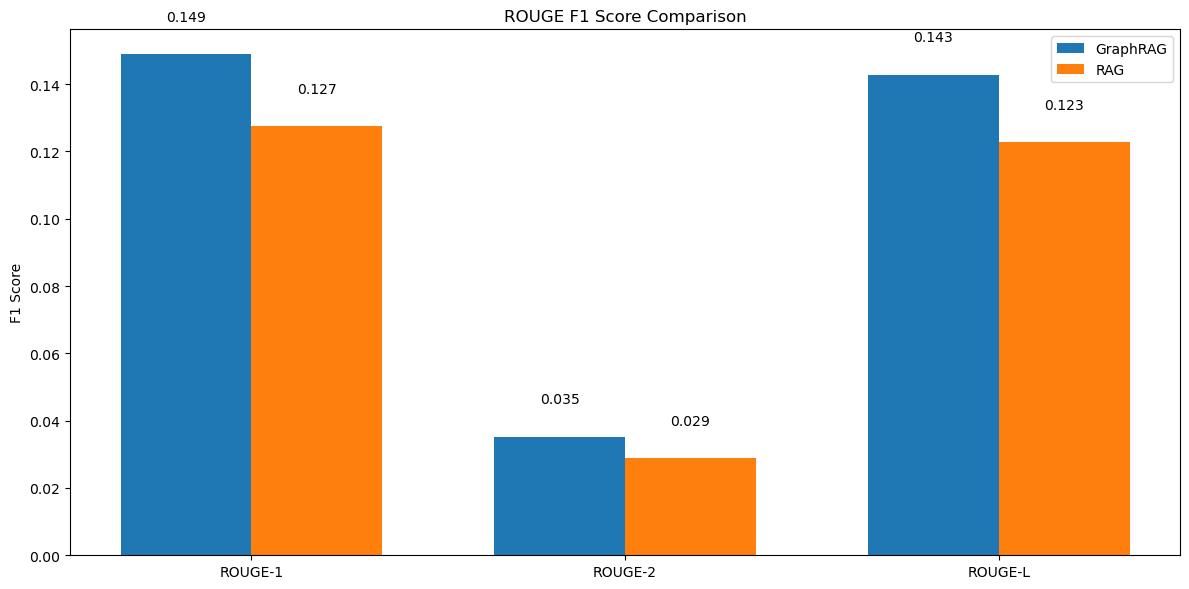

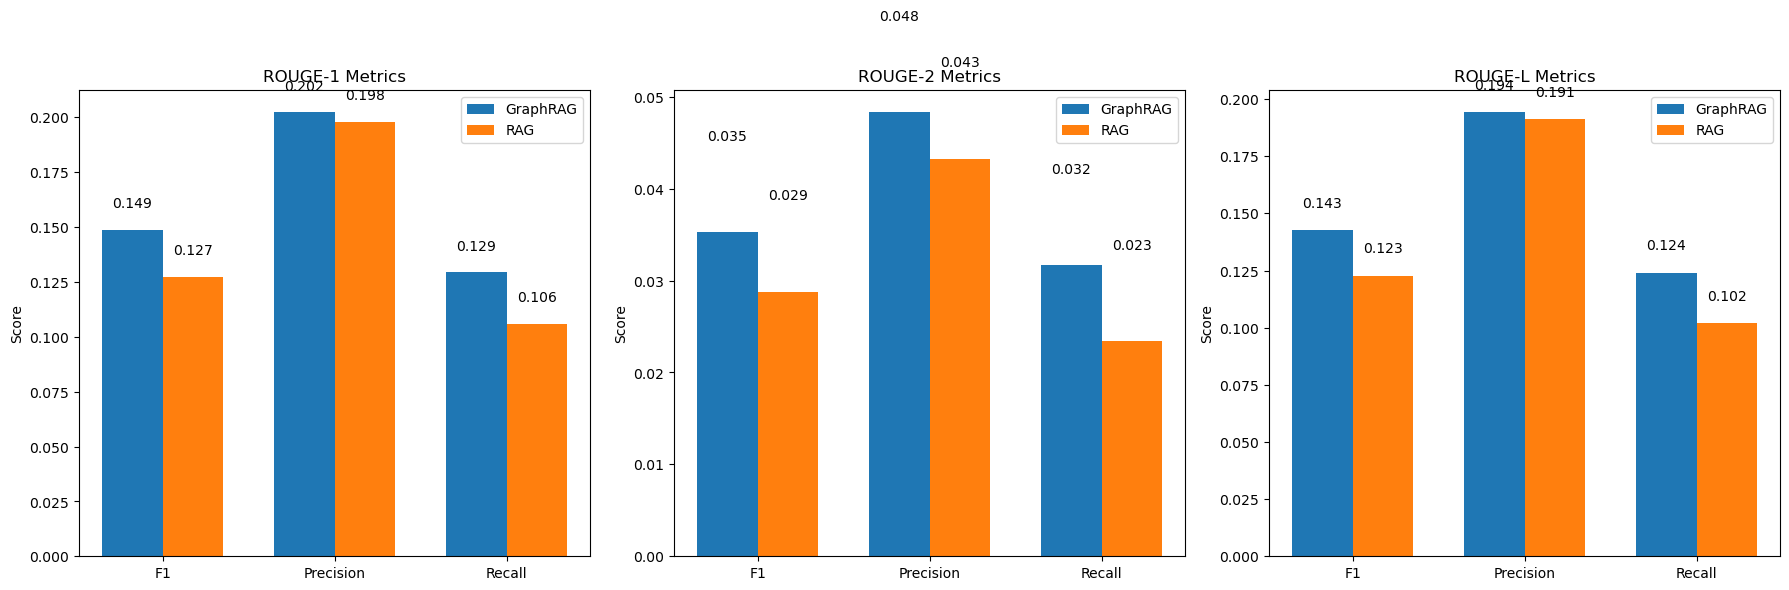

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create bar chart comparison
def create_comparison_charts(graphrag_scores, rag_scores):
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    graphrag_f1 = [graphrag_scores['rouge-1']['f'], graphrag_scores['rouge-2']['f'], graphrag_scores['rouge-l']['f']]
    rag_f1 = [rag_scores['rouge-1']['f'], rag_scores['rouge-2']['f'], rag_scores['rouge-l']['f']]
    
    # F1 Score Comparison
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, graphrag_f1, width, label='GraphRAG')
    plt.bar(x + width/2, rag_f1, width, label='RAG')
    
    plt.ylabel('F1 Score')
    plt.title('ROUGE F1 Score Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    
    # Add values on top of bars
    for i, v in enumerate(graphrag_f1):
        plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center')
    
    for i, v in enumerate(rag_f1):
        plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    plt.savefig('rouge_comparison.png')
    plt.show()
    
    # Create a more detailed comparison with all metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # For each ROUGE metric
    for i, rouge_type in enumerate(['rouge-1', 'rouge-2', 'rouge-l']):
        metrics = ['F1', 'Precision', 'Recall']
        graphrag_values = [graphrag_scores[rouge_type]['f'], 
                         graphrag_scores[rouge_type]['p'], 
                         graphrag_scores[rouge_type]['r']]
        rag_values = [rag_scores[rouge_type]['f'], 
                    rag_scores[rouge_type]['p'], 
                    rag_scores[rouge_type]['r']]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        axes[i].bar(x - width/2, graphrag_values, width, label='GraphRAG')
        axes[i].bar(x + width/2, rag_values, width, label='RAG')
        
        axes[i].set_ylabel('Score')
        axes[i].set_title(f'ROUGE-{rouge_type[-1].upper() if rouge_type[-1] != "l" else "L"} Metrics')
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(metrics)
        axes[i].legend()
        
        # Add values on top of bars
        for j, v in enumerate(graphrag_values):
            axes[i].text(j - width/2, v + 0.01, f'{v:.3f}', ha='center')
        
        for j, v in enumerate(rag_values):
            axes[i].text(j + width/2, v + 0.01, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    plt.savefig('rouge_detailed_comparison.png')
    plt.show()

# This function would be called after calculating the average scores
create_comparison_charts(avg_graphrag_scores, avg_rag_scores)

In [7]:
!pip install pandas nltk sacrebleu

In [8]:
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from sacrebleu import BLEU

# Load your CSV
df = pd.read_csv('evaluationSet.csv')

# Extract the columns
reference_answers = df['Reference Answer'].tolist()
graphrag_answers = df['GraphRAG Answer'].tolist()
rag_answers = df['RAG Answer'].tolist()

In [9]:
def preprocess_text(text):
    """Clean and tokenize Malayalam text"""
    if pd.isna(text):
        return []
    # Basic cleaning
    text = str(text).strip()
    # Tokenize by spaces (you might need more sophisticated Malayalam tokenization)
    tokens = text.split()
    return tokens

# Preprocess all answers
ref_tokens = [preprocess_text(ans) for ans in reference_answers]
graphrag_tokens = [preprocess_text(ans) for ans in graphrag_answers]
rag_tokens = [preprocess_text(ans) for ans in rag_answers]

In [11]:
# Convert back to strings for SacreBLEU
ref_strings = [' '.join(tokens) for tokens in ref_tokens]
graphrag_strings = [' '.join(tokens) for tokens in graphrag_tokens]
rag_strings = [' '.join(tokens) for tokens in rag_tokens]

bleu = BLEU()

# Calculate BLEU scores
graphrag_bleu = bleu.corpus_score(graphrag_strings, [ref_strings])
rag_bleu = bleu.corpus_score(rag_strings, [ref_strings])

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate average BLEU scores
avg_graphrag_bleu = np.mean(graphrag_bleu_scores)
avg_rag_bleu = np.mean(rag_bleu_scores)

print(f"Average GraphRAG BLEU Score: {avg_graphrag_bleu:.4f}")
print(f"Average RAG BLEU Score: {avg_rag_bleu:.4f}")
print(f"Difference: {avg_graphrag_bleu - avg_rag_bleu:.4f}")

# Add BLEU scores to your dataframe
df['GraphRAG_BLEU'] = graphrag_bleu_scores
df['RAG_BLEU'] = rag_bleu_scores
df['BLEU_Difference'] = df['GraphRAG_BLEU'] - df['RAG_BLEU']

# Save results
df.to_csv('results_with_bleu_scores.csv', index=False)

Average GraphRAG BLEU Score: 0.0058
Average RAG BLEU Score: 0.0029
Difference: 0.0029
